<a href="https://colab.research.google.com/github/ashikshafi08/Learning_Tensorflow/blob/main/Notebooks/05_Transfer_Learning_with_TensorFlow_Part_2_Fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Wed Mar 24 17:52:28 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Transfer Learning with Tensorflow: Fine Tuning 
In the previous notebook, we covered transfer learning feature extraction, now it's time to learn about a new kind of transfer learning which is **fine-tuning**.

## What we're going to cover

We're going to go through the follow with TensorFlow:

- Introduce fine-tuning, a type of transfer learning to modify a pre-trained model to be more suited to your data
- Using the **Keras Functional API** (a differnt way to build models in Keras)
- Using a smaller dataset to experiment faster (e.g. 1-10% of training samples of 10 classes of food)
- **Data augmentation** (how to make your training dataset more diverse without adding more data)

- Running a **series of modelling experiments** on our Food Vision data
  - Model 0: a transfer learning model using the Keras Functional API
  - Model 1: a feature extraction transfer learning model on 1% of the data with data augmentation
  - Model 2: a feature extraction transfer learning model on 10% of the data with data augmentation
  - Model 3: a fine-tuned transfer learning model on 10% of the data
  - Model 4: a fine-tuned transfer learning model on 100% of the data
- Introduce the **ModelCheckpoint callback** to save intermediate training results
- Compare model experiments results using TensorBoard

## Creating helper function
In previous notebooks, we've created a bunch of helper functions now we could re-write them all. However this is tedious. So it's a good idea to put all those function you want to use in a script, with that we can import them later depending upon our use. 

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-03-24 17:52:32--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9304 (9.1K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]   9.09K  --.-KB/s    in 0s      

2021-03-24 17:52:32 (100 MB/s) - ‘helper_functions.py’ saved [9304/9304]



In [3]:
# Import helper function 
from helper_functions import create_tensorboard_callback , plot_loss_curves , unzip_data , walk_through_dir

> **Dan Note:** If you're running this notebook in Colab, when it times out in Colab will delete `helper_functions.py` so you'll have to redownload it if you want access to your helper function. 

## Let's get some data 
This time we're going to see how to use the pre-trained models within `tf.keras.applications` and apply them to our own problem recognizing images of food. 

https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [4]:
# Get 10% of training data of 10 classes of Food101 
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data('10_food_classes_10_percent.zip')

--2021-03-24 17:52:34--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.7.144, 172.217.9.208, 172.217.12.240, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.7.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   103MB/s    in 1.6s    

2021-03-24 17:52:35 (103 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [5]:
# Check out how many images and sub directories are in our dataset 
walk_through_dir('10_food_classes_10_percent')

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ch

In [6]:
# Create training and test directory path 
train_dir = '10_food_classes_10_percent/train'
test_dir = '10_food_classes_10_percent/test'

In [7]:
import tensorflow as tf

# Global image size , batch 
IMG_SIZE = (224 , 224)
BATCH_SIZE = 32

# Using the image_dataset_from_directory
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory= train_dir , 
                                                                            image_size = IMG_SIZE , 
                                                                            label_mode = 'categorical' , 
                                                                            batch_size = BATCH_SIZE)

test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(test_dir, 
                                                                           image_size = IMG_SIZE,  
                                                                           label_mode = 'categorical')

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [8]:
train_data_10_percent

<BatchDataset shapes: ((None, 224, 224, 3), (None, 10)), types: (tf.float32, tf.float32)>

In [9]:
# Check out class names of our dataset 
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [10]:
# Seeing an example of batch
for images ,labels in train_data_10_percent.take(1): # take unravel a batch 
  print(images , labels)

tf.Tensor(
[[[[6.00000000e+00 1.30000000e+01 3.10000000e+01]
   [6.00000000e+00 1.30000000e+01 2.90000000e+01]
   [6.00000000e+00 1.30000000e+01 2.90000000e+01]
   ...
   [1.21147758e+02 6.18723373e+01 5.08571434e+01]
   [6.96884155e+01 2.92650547e+01 2.60711937e+01]
   [2.56376076e+01 2.46937799e+00 1.23972881e+00]]

  [[6.00000000e+00 1.30000000e+01 3.10000000e+01]
   [6.00000000e+00 1.30000000e+01 2.90000000e+01]
   [6.00000000e+00 1.30000000e+01 2.90000000e+01]
   ...
   [1.30729507e+02 6.80306091e+01 5.45153694e+01]
   [1.05198639e+02 5.89232368e+01 5.30661049e+01]
   [4.57237740e+01 1.37953768e+01 1.11575594e+01]]

  [[6.00000000e+00 1.30000000e+01 3.10000000e+01]
   [6.00000000e+00 1.30000000e+01 3.10000000e+01]
   [6.00000000e+00 1.30000000e+01 3.06632652e+01]
   ...
   [1.31857101e+02 6.54285507e+01 4.85255585e+01]
   [1.19989639e+02 6.55050125e+01 5.52601471e+01]
   [8.14432373e+01 3.88005219e+01 3.10811253e+01]]

  ...

  [[1.50341858e+02 1.10913330e+02 4.61275978e+01]
   [1

## Model 0: Building a Transfer Learning model (Feature Extraction) using the Keras Functional API

The sequential API is straight-forward, it runs our layers in Sequential order.

But the functional API gives us more flexibility with our model. 
https://www.tensorflow.org/guide/keras/functional

In [11]:
# 1. Create a base model with tf.keras.applications 
base_model = tf.keras.applications.EfficientNetB0(include_top= False)

# 2. Freeze the base_model  (so the underlying pre-trained patterns aren't updated during training)
base_model.trainable = False

# 3. Create inputs into our model 
inputs = tf.keras.layers.Input(shape = (224 , 224, 3) , name = 'input_layer')

# 4. If you're using a model like ResNet50V2 you will need to normalize the inputs (no need for EfficientNet)
# x = tf.keras.experimental.preprocessing.Rescaling(1 / 255.)(inputs)

# 5. Pass the inputs to the base model 
x = base_model(inputs)
print(f'Shape after passing inputs through base_model {x.shape}')

# 6. Average Pool the outputs of the base model (aggregate all the most important info, reduce the number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name = 'global_average_pooling_layer')(x) # atlast multiplying means passing onto another layer
print(f'Shape aftr Global Average Pooling 2D: {x.shape}')

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10 , activation ='softmax' , name ='output_layer')(x)

# 8. Combine the inputs with the outputs into a model 
model_0 = tf.keras.Model(inputs , outputs)

# 9. Compile the model 
model_0.compile(loss = tf.keras.losses.CategoricalCrossentropy(), 
                optimizer = tf.keras.optimizers.Adam() , 
                metrics = ['accuracy'])

# 10. Fit and save the history 
history_0 = model_0.fit(train_data_10_percent , 
                        steps_per_epoch = len(train_data_10_percent) , 
                        epochs = 5 , 
                        validation_data = test_data_10_percent , 
                        validation_steps = int( 0.25 *len(test_data_10_percent)) , 
                        callbacks = [create_tensorboard_callback('transfer_learning' , 
                                                                 '10_percent')])

16711680/16705208 [==============================] - 0s 0us/step
Shape after passing inputs through base_model (None, 7, 7, 1280)
Shape aftr Global Average Pooling 2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent/20210324-175246
Epoch 1/5
24/24 [==============================] - 45s 366ms/step - loss: 2.1119 - accuracy: 0.2704 - val_loss: 1.3713 - val_accuracy: 0.7007
Epoch 2/5
24/24 [==============================] - 6s 235ms/step - loss: 1.2395 - accuracy: 0.7214 - val_loss: 0.9708 - val_accuracy: 0.7780
Epoch 3/5
24/24 [==============================] - 6s 228ms/step - loss: 0.8765 - accuracy: 0.8030 - val_loss: 0.7624 - val_accuracy: 0.8355
Epoch 4/5
24/24 [==============================] - 6s 232ms/step - loss: 0.6992 - accuracy: 0.8454 - val_loss: 0.6930 - val_accuracy: 0.8306
Epoch 5/5
24/24 [==============================] - 6s 231ms/step - loss: 0.5984 - accuracy: 0.8655 - val_loss: 0.6201 - val_accuracy: 0.8536


In [12]:
# Evaluate on the full test data 
model_0.evaluate(test_data_10_percent)

79/79 [==============================] - 10s 126ms/step - loss: 0.6118 - accuracy: 0.8392


[0.6117897033691406, 0.8392000198364258]

In [13]:
# Check the layers in our base model 
for layer_number , layer in enumerate(base_model.layers):
  print(layer_number , layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_dwcon

In [14]:
# Summary of the base model 
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, None, None, 3 7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, None, None, 3 0           normalization[0][0]              
_____________________________________________________________________________________

In [15]:
# Summary of the model_0 
model_0.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


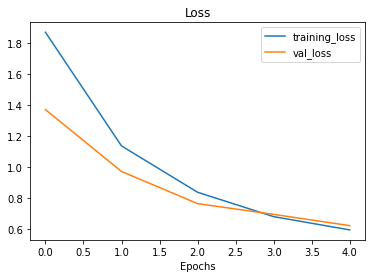

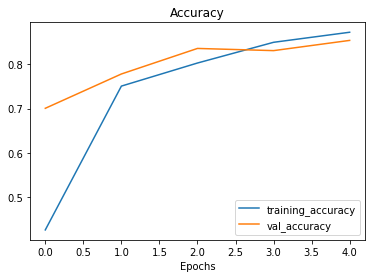

In [16]:
# Check our our model's training curves 
plot_loss_curves(history_0)

## Getting a feature vector from the trained model 

Let's demonstrate the Global Average Pooling 2D layer....

We have a tensor after our model goes through `base_model` of shape (None , 7 , 7 , 1280)....

But when it passes through GlobalAveragePooling2D layer it turns into (None , 1280). 

Let's use a similar shape tensor of (1,4,4,3) and then pass it to GlobalAveragePooling2D. 

In [17]:
# Define the input shape 
input_shape = (1 , 4, 4, 3)

# Create a random tensor 
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f'Random input tensor:\n {input_tensor}\n')

# Pass the random tensor to a GlobalAveragePool2d Layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor) # Same like using the functional api
print(f'2D Global average pooled random tensor:\n {global_average_pooled_tensor} ')

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D Global average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]] 


In [18]:
# Check the shape of different tensors 
print(f'Shape of the input_tensor: {input_tensor.shape}')
print(f'Shape of the GlobalAveragePooling2D layer: {global_average_pooled_tensor.shape}')

Shape of the input_tensor: (1, 4, 4, 3)
Shape of the GlobalAveragePooling2D layer: (1, 3)


In [19]:
# Lets replicate the GlobalAveragePool2D layer
tf.reduce_mean(input_tensor , axis = [1 , 2]) # Take mean across this axis (1, 2) 

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

Do the same thing above but with `GlobalMaxPool2D`

In [20]:
# Trying the same with GlobalMaxPool2d 
input_shape = (1 , 4, 4 , 3)

# Create the random tensor 
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f'Random input tensors"\n {input_tensor}\n')

# Pass the random tensor to a GlobalMaxPool2D
global_max_pooled_tensor = tf.keras.layers.GlobalMaxPool2D()(input_tensor)
print(f'2D Global Max Pooled random tensor:\n {global_max_pooled_tensor}')

Random input tensors"
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D Global Max Pooled random tensor:
 [[0.9058464 1.1603122 1.6994323]]


In [21]:
# Replicating the above 
tf.reduce_max(input_tensor , axis = [1 , 2]) # Take mean across this axis (1, 2) 

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[0.9058464, 1.1603122, 1.6994323]], dtype=float32)>

**Dan Note:** One of the reasons feature extraction transfer learning is named how it is is because what often happens is a pretrained model outputs a feature vector (a long tensor of numbers, in our case, this is the output of the tf.keras.layers.GlobalAveragePooling2D() layer) which can then be used to extract patterns out of.



# Running a series of transfer learning experiments

We've seen the incredible results transfer learning can get with the 10% of the training data, but how does it go with 1% of the training data... how about we setup a bunch of experiments to find out:

1. `model_1` - use feature extraction transfer learning with 1% of the training data with data augmentation. 
2. `model_2` - use feature extraction transfer learning with 10% of the training data with data augmentation. 
3. `model_3` - use fine tuning transfer learning on 10% of the training data with data augmentation.
4. `model_4` - use fine-tuning transfer learning on 100% of the training data with data augmentation. 

🔑**Dan Note:** throughout all experiments the same test dataset will be used to evaluate our model... this ensures consistency across evaluation metrics

### Getting and pre-processing data from model_1

In [22]:
# Download and unzip the data (preprocessed from food 101)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data('10_food_classes_1_percent.zip')

--2021-03-24 17:54:07--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.12.240, 172.217.15.112, 172.217.2.112, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.12.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   274MB/s    in 0.5s    

2021-03-24 17:54:07 (274 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [23]:
# Creating training and test dir 
train_dir_1_percent = '10_food_classes_1_percent/train'
test_dir = '10_food_classes_1_percent/test'

In [24]:
# How many images we're working with
walk_through_dir('10_food_classes_1_percent')

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_wings'

In [25]:
# Setup dataloaders
IMG_SIZE = (224 , 224)

train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(directory= train_dir_1_percent ,
                                                                           label_mode = 'categorical' , 
                                                                           image_size = IMG_SIZE , 
                                                                           batch_size = BATCH_SIZE , 
                                                                           shuffle = True)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory= test_dir , 
                                                                label_mode = 'categorical' , 
                                                                image_size = IMG_SIZE , 
                                                                batch_size = BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [26]:
len(train_data_1_percent) , len(test_dir)

(3, 30)

We are going to use Data Augmentation as a layer in our model this time, rather running through the ImageDataGenerators.

## Adding Data Augmentation right into the model

To add data augmentation right into our models, we can use the layers inside,

* `tf.keras.layers.experimental.preprocessing()`

We can see the benefit of doing this in the TensorFlow Data Augmentation documentation: https://www.tensorflow.org/tutorials/images/data_augmentation#option_1_make_the_preprocessing_layers_part_of_your_model

Off the top of our heads, after reading the docs, the benefits of using data augmentation inside the model are: 
* Pre-processing of images (augmenting them) happens on the GPU (much faster) rather than the CPU. 
* Image data augmentation only happens during the training, so we can still export the same model and use it else where. 


In [27]:
# Import everything back again 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers.experimental import preprocessing 

# Create data augmentation with horizantal flipping, rotations , zoom etc...
data_augmentation = keras.Sequential([
  preprocessing.RandomFlip('horizontal'), 
  preprocessing.RandomZoom(0.2), 
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomHeight(0.2) , 
  preprocessing.RandomWidth(0.2) , 
  # preprocessing.Rescale(1/255.) # Keep for models like Resnet50V2
] , name = 'data_augmentation')

### Visualize our data augmentation layers and see what's happening with our data.

Text(0.5, 1.0, 'This is the Augmented version of the random image of the class: {target_class}')

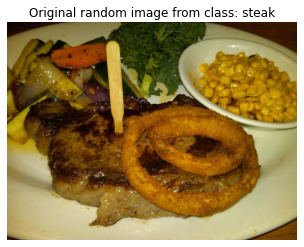

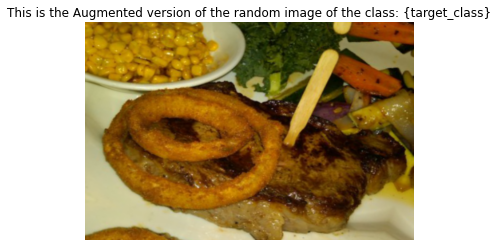

In [28]:
# View a random image and compare it to it's augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os 
import random 

target_class = random.choice(train_data_1_percent.class_names)
target_dir = '10_food_classes_1_percent/train/' + target_class

# Pick a random image 
random_image = random.choice(os.listdir(target_dir))
# the whole path 
random_image_path = target_dir + '/' + random_image

# Visualize this , read in the random image 
img = mpimg.imread(random_image_path)
plt.title(f'Original random image from class: {target_class}')
plt.axis(False)
plt.imshow(img)


# Now plot the augmented version of the image 
augmented_img = data_augmentation(tf.expand_dims(img , axis = 0)) # Adding a batch dimension
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.) # normalizing because it's not in the right format for matplotlib
plt.axis(False)
plt.title('This is the Augmented version of the random image of the class: {target_class}')

In [29]:
# Normalize 
(tf.expand_dims(img , axis = 0)).shape

TensorShape([1, 384, 512, 3])

## Model 1: Feature Extraction transfer learning on 1% of the data with data augmentation.

In [30]:
# Setup input and output shape, base model, freeze the base model layers
input_shape = (224 , 224 , 3)
base_model  = tf.keras.applications.EfficientNetB0(include_top= False)
base_model.trainable = False

# Create the input layer
inputs = tf.keras.layers.Input(shape= input_shape , name = 'input_layer')

# Add in data augmentation Sequential as a layer
x = data_augmentation(inputs)

# Give base model the inputs after they have been augmented (Dont train it)
x = base_model(x , training = False)

# Pool the output features of the base model (condense into feature vector)
x = tf.keras.layers.GlobalAveragePooling2D(name = 'pooling_layer')(x)

# Put a dense layer on as the output 
outputs = tf.keras.layers.Dense(10 , activation = 'softmax' , name ='output_layer')(x)

# Make a model using the inputs and outputs 
model_1 = keras.Model(inputs , outputs)


In [31]:
# Compile the model 
model_1.compile(loss = tf.keras.losses.CategoricalCrossentropy(), 
                optimizer = tf.keras.optimizers.Adam() , 
                metrics = ['accuracy'])

In [32]:
# Fit the model 
history_1 = model_1.fit(train_data_1_percent ,
                        epochs = 5 ,
                        steps_per_epoch = len(train_data_1_percent) , 
                        validation_data = test_data , 
                        validation_steps = int(0.2 * len(test_data)) , 
                        callbacks = [create_tensorboard_callback('transfer_learning' , 
                                                                 experiment_name = '1_percent_data_aug')])


Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20210324-175412
Epoch 1/5
3/3 [==============================] - 11s 3s/step - loss: 2.4710 - accuracy: 0.0488 - val_loss: 2.2275 - val_accuracy: 0.1458
Epoch 2/5
3/3 [==============================] - 4s 1s/step - loss: 2.1980 - accuracy: 0.1632 - val_loss: 2.0861 - val_accuracy: 0.2458
Epoch 3/5
3/3 [==============================] - 3s 1s/step - loss: 2.0185 - accuracy: 0.2913 - val_loss: 1.9812 - val_accuracy: 0.3292
Epoch 4/5
3/3 [==============================] - 4s 2s/step - loss: 1.7886 - accuracy: 0.4850 - val_loss: 1.9051 - val_accuracy: 0.4062
Epoch 5/5
3/3 [==============================] - 4s 2s/step - loss: 1.6663 - accuracy: 0.5813 - val_loss: 1.8033 - val_accuracy: 0.4354


In [33]:
# Getting the summary of the model
model_1.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
pooling_layer (GlobalAverage (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


In [34]:
# Evalaute on the full test data 
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 10s 121ms/step - loss: 1.8284 - accuracy: 0.4172


[1.8283823728561401, 0.4171999990940094]

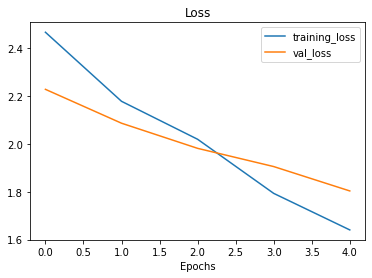

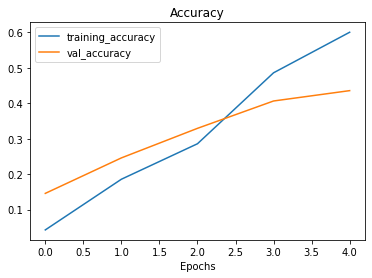

In [35]:
# Getting the loss curve 
plot_loss_curves(history_1)

## Building Model 2 with data augmentation layer and 10% of the training data 

In [36]:
# Getting the data in directories 
train_dir_10_percent = '10_food_classes_10_percent/train'
test_dir = '10_food_classes_10_percent/test'

In [37]:
# How many images are in each sub-directory? 
walk_through_dir(train_dir_10_percent)

There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.


In [38]:
# Importing our data in the dataloaders from the directories
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent , 
                                                                            image_size = IMG_SIZE , 
                                                                            batch_size = BATCH_SIZE , 
                                                                            label_mode = 'categorical' , 
                                                                            shuffle = True , 
                                                                            seed = 42)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir , 
                                                                image_size = IMG_SIZE , 
                                                                batch_size = BATCH_SIZE , 
                                                                label_mode = 'categorical' , 
                                                                seed = 42)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [39]:
# Construct a model for data augmentation with Sequential API
from tensorflow.keras.layers.experimental import preprocessing 


data_augmentation_10_percent = tf.keras.Sequential([
  preprocessing.RandomFlip('horizontal') , 
  preprocessing.RandomZoom(0.2) , 
  preprocessing.RandomRotation(0.2) , 
  preprocessing.RandomWidth(0.2), 
  preprocessing.RandomHeight(0.2)
] , name = 'data_augmentation_10_percent')

10_food_classes_10_percent/train/grilled_salmon


Text(0.5, 1.0, 'This is the Augmented version of the random image of the class: {target_class}')

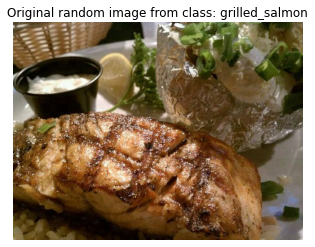

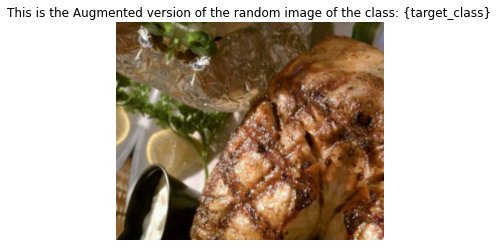

In [40]:
# View a random image and compare it to it's augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os 
import random 

target_class = random.choice(train_data_10_percent.class_names)
target_dir = '10_food_classes_10_percent/train/' + target_class
print(target_dir)

# Pick a random image 
random_image = random.choice(os.listdir(target_dir))
# the whole path 
random_image_path = target_dir + '/' + random_image

# Visualize this , read in the random image 
img = mpimg.imread(random_image_path)
plt.title(f'Original random image from class: {target_class}')
plt.axis(False)
plt.imshow(img)


# Now plot the augmented version of the image 
augmented_img = data_augmentation_10_percent(tf.expand_dims(img , axis = 0)) # Adding a batch dimension
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.) # normalizing because it's not in the right format for matplotlib
plt.axis(False)
plt.title('This is the Augmented version of the random image of the class: {target_class}')

In [41]:
# Setup input shape at first 
input_shape = (224, 224, 3)

# Setting up our base model (EfficientNet_b0) 
base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False # Freezing the layers 

# Create the input layer 
inputs = tf.keras.layers.Input(shape = input_shape , name = 'input_layer')

# Add in the data augmentation Sequential as a layer 
x = data_augmentation_10_percent(inputs) 

# Give base model the inputs after they have been augmented
x = base_model(x , training = False) # A model so we pass in the x 

# Pool the output features of the base model 
x = tf.keras.layers.GlobalAveragePooling2D(name = 'pooling_layer')(x)

# A dense layer for the output 
outputs = tf.keras.layers.Dense(10 , activation='softmax' , name = 'output_layer')(x)

# Make a model using the inputs and outputs 
model_2 = keras.Model(inputs , outputs)

In [42]:
# Compile the model 
model_2.compile(loss = tf.keras.losses.CategoricalCrossentropy(), 
                optimizer = tf.keras.optimizers.Adam(), 
                metrics = ['accuracy'])



In [43]:
# Fit the model 
history_without_callback = model_2.fit(train_data_10_percent  , 
                        epochs = 5, 
                        steps_per_epoch = len(train_data_10_percent) , 
                        validation_data = test_data , 
                        validation_steps = len(test_data) , 
                        callbacks = [create_tensorboard_callback(dir_name = 'transfer_learning' , 
                                                                 experiment_name = '10_percent_data_augmented')])

Saving TensorBoard log files to: transfer_learning/10_percent_data_augmented/20210324-175452
Epoch 1/5
24/24 [==============================] - 27s 934ms/step - loss: 2.2058 - accuracy: 0.1923 - val_loss: 1.5135 - val_accuracy: 0.6308
Epoch 2/5
24/24 [==============================] - 18s 762ms/step - loss: 1.4362 - accuracy: 0.6353 - val_loss: 1.0674 - val_accuracy: 0.7592
Epoch 3/5
24/24 [==============================] - 18s 743ms/step - loss: 1.1221 - accuracy: 0.7477 - val_loss: 0.8723 - val_accuracy: 0.7832
Epoch 4/5
24/24 [==============================] - 18s 740ms/step - loss: 0.9473 - accuracy: 0.7554 - val_loss: 0.7611 - val_accuracy: 0.8060
Epoch 5/5
24/24 [==============================] - 18s 729ms/step - loss: 0.8032 - accuracy: 0.7778 - val_loss: 0.7008 - val_accuracy: 0.8108


Why training is equal to False in  `x = base_model(x , training = False)`? 
[Check this link](https://keras.io/guides/transfer_learning/#build-a-model)

### Creating a ModelCheckpoint Callback

The ModelCheckpoint Callback intermediately saves our model (the full model or just the weights) during training. This is useful so we can come back and start where we left off. 

In [44]:
# Set checkpoint path (a checkpoint where our model will get saved)
checkpoint_path = 'ten_percent_model_checkpoints_weights/checkpoint.ckpt' # ckpt --> extension for checkpoint

# Create ModelCheckpoint callback thats saves the model's weight only 
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath= checkpoint_path , 
                                                         save_weights_only = True , 
                                                         save_best_only = False , 
                                                         save_freq = 'epoch' , # save every epoch
                                                         verbose = 1 ) 

#### Fit model 2 with the ModelCheckpoint Callback

In [45]:
# Fit the model 
history_10_percent_data_aug = model_2.fit(train_data_10_percent  , 
                        epochs = 5, 
                        steps_per_epoch = len(train_data_10_percent) , 
                        validation_data = test_data , 
                        validation_steps = len(test_data) , 
                        callbacks = [create_tensorboard_callback(dir_name = 'transfer_learning' , 
                                                                 experiment_name = '10_percent_data_augmented') , checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_augmented/20210324-175631
Epoch 1/5
24/24 [==============================] - 18s 720ms/step - loss: 0.7376 - accuracy: 0.8200 - val_loss: 0.6608 - val_accuracy: 0.8136

Epoch 00001: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 2/5
24/24 [==============================] - 17s 709ms/step - loss: 0.6754 - accuracy: 0.8240 - val_loss: 0.6221 - val_accuracy: 0.8264

Epoch 00002: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 3/5
24/24 [==============================] - 16s 672ms/step - loss: 0.6089 - accuracy: 0.8533 - val_loss: 0.6023 - val_accuracy: 0.8216

Epoch 00003: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 4/5
24/24 [==============================] - 16s 668ms/step - loss: 0.5907 - accuracy: 0.8400 - val_loss: 0.5765 - val_accuracy: 0.8292

Epoch 00004: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
Epo

In [46]:
# What were model_0 results
model_0.evaluate(test_data)

79/79 [==============================] - 11s 121ms/step - loss: 0.6118 - accuracy: 0.8392


[0.6117897033691406, 0.8392000198364258]

In [47]:
# 10% training data with augmentation
results_10_percent_data_aug = model_2.evaluate(test_data)

79/79 [==============================] - 10s 121ms/step - loss: 0.5625 - accuracy: 0.8344


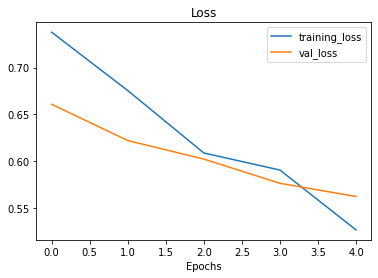

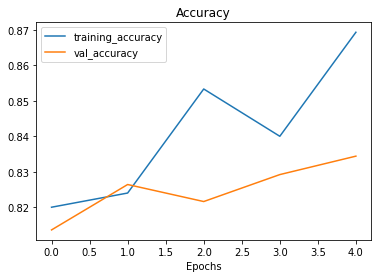

In [48]:
# plot the model loss curve 
plot_loss_curves(history_10_percent_data_aug)

Looking at the loss curves, it seems if we keep training for few more epochs our results might get better. 

### Loading in checkpointed weights

Loading in checkpointed weights returns a model to a specific checkpoint. This is helpful when training takes a long time. 

In [49]:
# Load in saved model weights and evaluate. the model 
model_2.load_weights(checkpoint_path) # filepath to the weights

In [50]:
# Evalaute model_2 with loaded weights 
loaded_weight_model_results = model_2.evaluate(test_data)
loaded_weight_model_results

79/79 [==============================] - 10s 120ms/step - loss: 0.5625 - accuracy: 0.8344


[0.5624614953994751, 0.8343999981880188]

In [51]:
# If the results from our previously evaluated model_2 matched the loaded weights, everything has worked!
loaded_weight_model_results == results_10_percent_data_aug

True

In [52]:
# Check to see if loaded model results are very close to the previous non loaded model results 
import numpy as np 
np.isclose(np.array(results_10_percent_data_aug) , np.array(loaded_weight_model_results))

array([ True,  True])

In [53]:
# Check the difference (precision)
print((np.array(results_10_percent_data_aug)) - (np.array(loaded_weight_model_results)))

[0. 0.]


# Fine Tuning Baby! 
## Model 3: Fine-tuning an existing model on 10% of the data. 

> **Note:** Fine-tuning usually works best after training a feature extraction model for few epochs with large amount of custom data.

In [54]:
# Layers in our loaded model 
model_2.layers # Loaded the weights for 5 epochs 

In [55]:
# Are these layers are trainable? 
for layer in model_2.layers:
  print(layer , layer.trainable ) # Functional layer --> base layer which is not trainable here

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7efe822bbf90> True
<tensorflow.python.keras.engine.sequential.Sequential object at 0x7efe822e8890> True
<tensorflow.python.keras.engine.functional.Functional object at 0x7efe30d6d650> False
<tensorflow.python.keras.layers.pooling.GlobalAveragePooling2D object at 0x7efe30c15710> True
<tensorflow.python.keras.layers.core.Dense object at 0x7efe309d3f50> True


In [56]:
# What layers in our base model and are they trainable?
for i, layer in enumerate(model_2.layers[2].layers):
  print(i , layer.name , layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [57]:
# How many trainable variables are there in our base model?
# trainable variables --> weights that can be updated
print(len(model_2.layers[2].trainable_variables))

0


In [58]:
# To begin fine-tuning let's start by setting the last 10 layers of our base model .trainable=True
base_model.trainable = True 

# Freeze all layers except the last 10
for layer in base_model.layers[:-10]:
  layer.trainable = False
  print(layer.name)

# Recompile (we have to recompile our model everytime we make a change)
model_2.compile(loss = tf.keras.losses.CategoricalCrossentropy(), 
                optimizer = tf.keras.optimizers.Adam(lr = 0.0001) , # when fine-tuning typically lower the learning rate 10X
                metrics = ['accuracy'])

input_3
rescaling_2
normalization_2
stem_conv_pad
stem_conv
stem_bn
stem_activation
block1a_dwconv
block1a_bn
block1a_activation
block1a_se_squeeze
block1a_se_reshape
block1a_se_reduce
block1a_se_expand
block1a_se_excite
block1a_project_conv
block1a_project_bn
block2a_expand_conv
block2a_expand_bn
block2a_expand_activation
block2a_dwconv_pad
block2a_dwconv
block2a_bn
block2a_activation
block2a_se_squeeze
block2a_se_reshape
block2a_se_reduce
block2a_se_expand
block2a_se_excite
block2a_project_conv
block2a_project_bn
block2b_expand_conv
block2b_expand_bn
block2b_expand_activation
block2b_dwconv
block2b_bn
block2b_activation
block2b_se_squeeze
block2b_se_reshape
block2b_se_reduce
block2b_se_expand
block2b_se_excite
block2b_project_conv
block2b_project_bn
block2b_drop
block2b_add
block3a_expand_conv
block3a_expand_bn
block3a_expand_activation
block3a_dwconv_pad
block3a_dwconv
block3a_bn
block3a_activation
block3a_se_squeeze
block3a_se_reshape
block3a_se_reduce
block3a_se_expand
block3a_se_

> **Note:** When using fine-tuning it's best practices to lower your learning rate by same amount. How much? This is a hyperparameter you can tune. But a good rule of thumb is atleast 10X (though different sources will claim other values). A good resource for this information is

https://www.google.com/search?q=ULMfit&oq=ULMfit+&aqs=chrome..69i57.2214j0j1&sourceid=chrome&ie=UTF-8

In [59]:
# Recompile (we have to recompile our model everytime we make a change)
model_2.compile(loss = tf.keras.losses.CategoricalCrossentropy(), 
                optimizer = tf.keras.optimizers.Adam() , 
                metrics = ['accuracy'])

In [60]:
# Check which layers are trainable 
for layer_number , layer in enumerate(model_2.layers[2].layers):
  print(layer_number , layer.name , layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [61]:
# Now we've unfrozen some of the layers closer to the top, how many trainable variables are there? 
print(len(model_2.trainable_variables))

12


In [62]:
# Fine tune for another 5 epochs 
initial_epochs = 5
fine_tune_epochs = initial_epochs + 5

# Refit the model (same as model_2 except with more trainable layers)
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent , 
                                               epochs = fine_tune_epochs ,  
                                               validation_data = test_data , 
                                               validation_steps = int(0.25 *len(test_data)) , 
                                               initial_epoch = history_with_callback.epoch[-1] , # Start training from previous last epoch
                                               callbacks = [create_tensorboard_callback('transfer_learning' , 
                                                                                        '10_percent_fine_tuning_last10')] )

NameError: ignored

In [ ]:
# Evaluate the fine tune model (model_3 which is acutally model_2 fine tuned for another 5 epochs)
results_fine_tune_10_percent = model_2.evaluate(test_data)

In [ ]:
# Before fine-tunig 
results_10_percent_data_aug

#### Comparing our model's results before and after fine-tuning

In [ ]:
# Plot the loss curve
plot_loss_curves(history_fine_10_percent_data_aug)

Our epochs start from 5 - 10, whereas here it's not the case. So we need to create a function which does that comparison.

The `plot_loss_curves` works great with the models which have only been fit once, however, we want something to compare one series of running `fit()` with another (e.g before and after fine-tuning).

In [63]:
# Let's create a function to compare training histories
def compare_historys(original_history , new_history , initial_epochs = 5): 
  '''
  Compare two tensorflow history objects
  '''

  # Get original history measurements
  acc = original_history.history['accuracy']
  loss = original_history.history['loss']

  val_acc = original_history.history['val_accuracy']
  val_loss = original_history.history['val_loss']

  # Combine original history 
  total_acc = acc + new_history.history['accuracy']
  total_loss = loss + new_history.history['loss']

  total_val_acc = val_acc + new_history.history['val_accuracy']
  total_val_loss = val_loss + new_history.history['val_loss']

  # Make the plots for accuracy
  plt.figure(figsize =(8 , 8))
  plt.subplot(2 , 1, 1)
  plt.plot(total_acc , label = 'Training Accuracy')
  plt.plot(total_val_acc , label ='Val Accuracy')
  plt.plot([initial_epochs-1 , initial_epochs-1] , plt.ylim() , label = 'Start Fine-tuning...')
  plt.legend(loc ='lower right')
  plt.title('Training and Validation Accuracy')

  # Make the plots for loss
  plt.figure(figsize =(8 , 8))
  plt.subplot(2 , 1, 2)
  plt.plot(total_loss , label = 'Training Loss')
  plt.plot(total_val_loss , label ='Val Loss')
  plt.plot([initial_epochs-1 , initial_epochs-1] , plt.ylim() , label = 'Start Fine-tuning...')
  plt.legend(loc ='upper right')
  plt.title('Training and Validation Loss')





In [64]:
compare_historys(original_history= history_with_callback , 
                 new_history = history_fine_10_percent_data_aug , 
                 initial_epochs = 5)

NameError: ignored

Something's wrong with my model, gotta fix it!

## Model 4: Fine-tuning and existing model on all of the data

In [65]:
# Download and unzip 10 classes of food 101 data with all images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip_data('10_food_classes_all_data.zip')


--2021-03-24 18:00:46--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.5.240, 172.217.7.144, 172.217.164.176, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.5.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M   144MB/s    in 3.4s    

2021-03-24 18:00:49 (144 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [66]:
# Setup training and test dir
train_dir_all_data = '10_food_classes_all_data/train'
test_dir = '10_food_classes_all_data/test'

In [67]:
# How many images are we working with now? 
walk_through_dir(train_dir_all_data)

There are 10 directories and 0 images in '10_food_classes_all_data/train'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ice_cream'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/hamburger'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ramen'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/steak'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/pizza'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/grilled_salmon'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_curry'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/fried_rice'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/sushi'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_wings'.


In [68]:
# Setup data inputs 
import tensorflow as tf
IMG_SIZE = (224 , 224)
BATCH_SIZE = 32

train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir_all_data , 
                                                                                 image_size = IMG_SIZE , 
                                                                                 batch_size = BATCH_SIZE , 
                                                                                 label_mode = 'categorical' )

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir , 
                                                                image_size= IMG_SIZE , 
                                                                label_mode = 'categorical' )

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


The test dataset we've loaded in is the same as what we've been using for previous.

And I will be creating the `model_2` again since the one I did before showing weird results, will call this one as `new_model_2`.

In [69]:
# Putting most of em into one cell 
train_dir_10_percent = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)


Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [70]:
from tensorflow.keras import layers 
from tensorflow.keras.layers.experimental import preprocessing 
from tensorflow.keras.models import Sequential

# Build data augmentation as a layer 
data_augmentation = Sequential([
  preprocessing.RandomFlip('horizontal') , 
  preprocessing.RandomHeight(0.2), 
  preprocessing.RandomWidth(0.2) , 
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomRotation(0.2)
] , name = 'data_augmentation')

# Setup the input shape to our model 
input_shape = (224 ,224 , 3)

# Create a frozen base model 
base_model = tf.keras.applications.EfficientNetB0(include_top= False) # we wanna add our own top (output layer)
base_model.trainable = False

# Create input and output layers 
inputs = layers.Input(shape = input_shape , name = 'input_layer') # Create input layer 
x = data_augmentation(inputs) # augment our training 

# Creating the efficientnetb0 model
x = base_model(x , training = False) # Passing augmented images to our base model 
x = layers.GlobalAveragePooling2D(name = 'global_average_pooling2D_layer')(x)
outputs = layers.Dense(10 , activation ='softmax' , name ='output_layer')(x)

# Model taking inputs and outputs 
new_model_2 = keras.Model(inputs , outputs)

# Compile our model 
new_model_2.compile(loss = tf.keras.losses.CategoricalCrossentropy(), 
                    optimizer = tf.keras.optimizers.Adam(lr = 0.001) , 
                    metrics = ['accuracy'])


In [71]:
# Setup checkpoint path 
new_checkpoint_path = "new_ten_percent_model_checkpoints_weights/checkpoint.ckpt" 

# Create a ModelCheckpoint callback that saves weights only 
new_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath = new_checkpoint_path ,  
                                                             save_weights_only = True , # Set to False to save the entire model
                                                             save_best_only = False , # set to True to save only the best model instead of a model every epoch
                                                             save_freq = 'epoch' , # save every epoch
                                                             verbose = 1)

In [72]:
# Fit the model saving every epoch 
initial_epochs = 5
history_10_percent_data_aug = new_model_2.fit(train_data_10_percent,
                                          epochs=initial_epochs,
                                          validation_data=test_data,
                                          validation_steps=int(0.25 * len(test_data)), # do less steps per validation (quicker)
                                          callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_data_aug"), 
                                                     new_checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20210324-180058
Epoch 1/5
24/24 [==============================] - 17s 509ms/step - loss: 2.1645 - accuracy: 0.2391 - val_loss: 1.4900 - val_accuracy: 0.6414

Epoch 00001: saving model to new_ten_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 2/5
24/24 [==============================] - 9s 378ms/step - loss: 1.4508 - accuracy: 0.6221 - val_loss: 1.0839 - val_accuracy: 0.7385

Epoch 00002: saving model to new_ten_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 3/5
24/24 [==============================] - 9s 367ms/step - loss: 1.1286 - accuracy: 0.7388 - val_loss: 0.8701 - val_accuracy: 0.7763

Epoch 00003: saving model to new_ten_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 4/5
24/24 [==============================] - 9s 379ms/step - loss: 0.9351 - accuracy: 0.7643 - val_loss: 0.7739 - val_accuracy: 0.8010

Epoch 00004: saving model to new_ten_percent_model_checkpoints_weights/checkpoint.c

In [73]:
# Evaluate on the test data
results_10_percent_data_aug = new_model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 10s 119ms/step - loss: 0.7019 - accuracy: 0.8120


[0.7019120454788208, 0.8119999766349792]

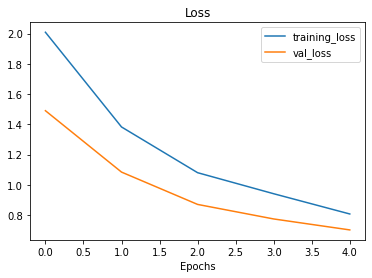

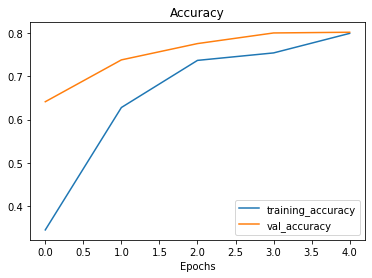

In [74]:
# Plot model loss curves
plot_loss_curves(history_10_percent_data_aug)

In [75]:
#  Load in saved model weights and evaluate model
new_model_2.load_weights(new_checkpoint_path)
new_loaded_weights_model_results = new_model_2.evaluate(test_data)

79/79 [==============================] - 10s 119ms/step - loss: 0.7019 - accuracy: 0.8120


**Fine tuning** 

In [76]:
base_model.trainable = True

# Freeze all layers except for the
for layer in base_model.layers[:-10]:
  layer.trainable = False

# Recompile the model (always recompile after any adjustments to a model)
new_model_2.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(lr=0.0001), # lr is 10x lower than before for fine-tuning
              metrics=["accuracy"])

In [77]:
# Check which layers are tuneable (trainable)
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_4 False
1 rescaling_3 False
2 normalization_3 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [78]:
print(len(new_model_2.trainable_variables))


12


In [79]:
# Fine tune for another 5 epochs 
fine_tune_epochs = initial_epochs + 5

# Refit the model (same as new_model_2 except wit more trainable layers)
history_fine_10_percent_data_aug = new_model_2.fit(train_data_10_percent , 
                                                   epochs = fine_tune_epochs ,
                                                   initial_epoch = history_10_percent_data_aug.epoch[-1] ,
                                                   validation_data = test_data , 
                                                   validation_steps = int(0.25 * len(test_data)) , 
                                                   callbacks = [create_tensorboard_callback('transfer_learning' , 
                                                                                            "10_percent_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20210324-180215
Epoch 5/10
24/24 [==============================] - 17s 503ms/step - loss: 0.7152 - accuracy: 0.8104 - val_loss: 0.5925 - val_accuracy: 0.8010
Epoch 6/10
24/24 [==============================] - 9s 364ms/step - loss: 0.5348 - accuracy: 0.8371 - val_loss: 0.5430 - val_accuracy: 0.8289
Epoch 7/10
24/24 [==============================] - 9s 370ms/step - loss: 0.4717 - accuracy: 0.8629 - val_loss: 0.5650 - val_accuracy: 0.8026
Epoch 8/10
24/24 [==============================] - 10s 395ms/step - loss: 0.4444 - accuracy: 0.8749 - val_loss: 0.5443 - val_accuracy: 0.8059
Epoch 9/10
24/24 [==============================] - 9s 370ms/step - loss: 0.4487 - accuracy: 0.8568 - val_loss: 0.5110 - val_accuracy: 0.8240
Epoch 10/10
24/24 [==============================] - 9s 360ms/step - loss: 0.3835 - accuracy: 0.8840 - val_loss: 0.5653 - val_accuracy: 0.8158


In [80]:
# Evaluate the model on the test data
results_fine_tune_10_percent = new_model_2.evaluate(test_data)

79/79 [==============================] - 10s 119ms/step - loss: 0.4970 - accuracy: 0.8360


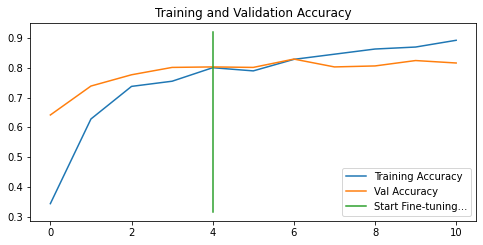

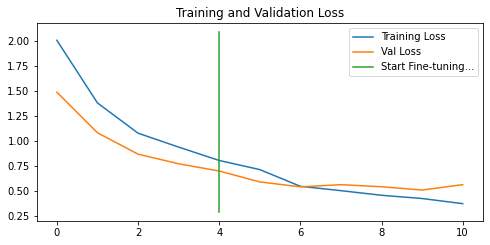

In [81]:
# Now we're gonna plot and see how the curves look
compare_historys(original_history=history_10_percent_data_aug, 
                 new_history=history_fine_10_percent_data_aug, 
                 initial_epochs=5)

**Perfect** I think I might have messed up freezing and unfreezing or mixing up things in te the modelling section. It's cool I went over again and typed out everything by hand to fix this curve.

### Back to `model_4` where we will train with 10% of the data with full images. 

The test dataset we've loaded in is the same as what we've been using for previous experiments (all experiments have used the same test dataset). Let's verify this

In [82]:
# Evalaute new_model_2 (this is fine-tuned on the 10% of the data)
new_model_2.evaluate(test_data)

79/79 [==============================] - 10s 118ms/step - loss: 0.4970 - accuracy: 0.8360


[0.4970260262489319, 0.8360000252723694]

In [83]:
# Should match the results 
results_fine_tune_10_percent

[0.49702611565589905, 0.8360000252723694]

We are going to revert our `new_model_2` back to the checkpointed version. Because our workflow is, 
- Feature Extract the model. (checkpointed version where feature extracted stored)
- Fine tune it. 

To train a fine_tuning model `model_4` we need to revert `model_2` back to it's feature extraction weights. 

In [84]:
# Loading weights from the checkpoints, that way we can fine-tune the same stage the 10% data model was fine-tuned from
new_model_2.load_weights(new_checkpoint_path)

In [85]:
# Let's evaluate our model on the new_model_2 where we loaded_weights
new_model_2.evaluate(test_data) # this should be worse

79/79 [==============================] - 10s 118ms/step - loss: 0.7019 - accuracy: 0.8120


[0.7019121050834656, 0.8119999766349792]

In [88]:
# Check to see if our new_model_2 has been reverted back to feature exttraction results
results_10_percent_data_aug  # Evaluated on feature extracted model

[0.7019120454788208, 0.8119999766349792]

Alright, the previous steps might seem quite confusing but all we've done so far is:
1. Trained a feature extraction transfer learning model for 5 epochs on 10% of the data with data augmentation (`new_model_2`) and we **saved model's weights using `ModelCheckpoint` callback**.
2.  And we fine tuned the same model on the same 10% of the **data for a furter 5 epochs with the top10 layers of a base model unfrozen** (`model_3`).
3. Saved the results and training logs each time. 
4. Re-loaded the model from Step-1 (feature extraction model) to do the same steps as Step-2 except this time **we're going to use all of the data `model_4`**.

In [89]:
# Check which layers are trainable 
for layer_number , layer in enumerate(new_model_2.layers):
  print(layer_number , layer.name , layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetb0 True
3 global_average_pooling2D_layer True
4 output_layer True


Because it prints out `True` if any of the layers in the model is set to `True` but we know that only the top 10 layers are trainable and rest are not trainable.

In [90]:
# Now let's drill into our base_model (efficientnet_b0) and see what layers are trainable 
for layer_number , layer in enumerate(new_model_2.layers[2].layers):
  print(layer_number , layer.name , layer.trainable)

0 input_4 False
1 rescaling_3 False
2 normalization_3 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

After making a change to a model, now it's time ro re-compile the model before fitting. The changed we made to the `new_model_2` is we reverted back the weights (feature extractor one) still if we ain't gonna **re-compile** it won't update the weights. 

In [91]:
# Compile 
new_model_2.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
                    optimizer = tf.keras.optimizers.Adam(lr = 0.0001) , # lower it by 10x
                    metrics =['accuracy'])

In [96]:
initial_epochs

5

In [95]:
# Fitting the model (fine tune the model) to ur 100% training data 
fine_tune_epochs = initial_epochs + 5

history_fine_ten_classes_full = new_model_2.fit(train_data_10_classes_full , 
                                                epochs = fine_tune_epochs ,
                                                validation_data = test_data , 
                                                validation_steps = int(0.25 * len(test_data)) , 
                                                initial_epoch = history_10_percent_data_aug.epoch[-1] , 
                                                callbacks = [create_tensorboard_callback('transfer_learning' , 
                                                                                         'fine_tune_full_train_data')])


Saving TensorBoard log files to: transfer_learning/fine_tune_full_train_data/20210324-185952
Epoch 5/10
235/235 [==============================] - 53s 205ms/step - loss: 0.7963 - accuracy: 0.7544 - val_loss: 0.4254 - val_accuracy: 0.8602
Epoch 6/10
235/235 [==============================] - 56s 235ms/step - loss: 0.6297 - accuracy: 0.8019 - val_loss: 0.4128 - val_accuracy: 0.8618
Epoch 7/10
235/235 [==============================] - 57s 240ms/step - loss: 0.5458 - accuracy: 0.8219 - val_loss: 0.3996 - val_accuracy: 0.8487
Epoch 8/10
235/235 [==============================] - 50s 211ms/step - loss: 0.4954 - accuracy: 0.8429 - val_loss: 0.3640 - val_accuracy: 0.8734
Epoch 9/10
235/235 [==============================] - 51s 214ms/step - loss: 0.4666 - accuracy: 0.8483 - val_loss: 0.3815 - val_accuracy: 0.8816
Epoch 10/10
235/235 [==============================] - 47s 197ms/step - loss: 0.4282 - accuracy: 0.8630 - val_loss: 0.3611 - val_accuracy: 0.8734


In [97]:
# Let's evaluate on the full test data
results_fine_tune_full_data =  new_model_2.evaluate(test_data)

79/79 [==============================] - 10s 121ms/step - loss: 0.3390 - accuracy: 0.8904


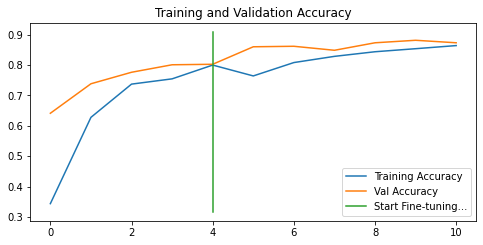

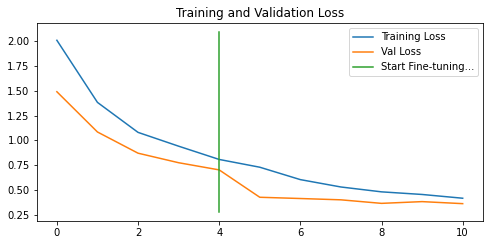

In [98]:
# How did the fine-tuning go with the data? 
compare_historys(original_history= history_10_percent_data_aug , 
                 new_history = history_fine_ten_classes_full , 
                 initial_epochs = 5)

## Viewing our experiment data on TensorBoard

In [101]:
# View tensorboard tensorflow logs of transfer learning modelling experiments(should ~ 4 models)
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./transfer_learning \
  --name 'Transfer Learning Experiments with 10 Food101 classes' \
  --description 'A series of different transfer learning experiments with variying amount of data and fine-tuning'\
  --one_shot

My Tensorboard experiments are available at https://tensorboard.dev/experiment/IZcJeJtKROK8R9sKNgRAMQ/#scalars